# Data Wrangling

### Step 1. Load Modules

In [ ]:
# Import modules
import pandas as pd
import numpy as np
import datetime
import os as os
import matplotlib.pyplot as plt

# Set so jupyter displays all columns
pd.set_option('display.max_columns', False)

### Step 2. Data Collection

In [ ]:
# Change to directory with raw data
os.chdir('../data/raw')

In [22]:
# Load in csv files
sales = pd.read_csv('sales data-set.csv')
features = pd.read_csv('Features data set.csv')
stores = pd.read_csv('stores data-set.csv')

#### Inspect DataFrames to understand structure

In [29]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [30]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


In [31]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [32]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [33]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [34]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


#### Convert 'Date' columns to datetime objects

In [62]:
sales['Date'] = pd.to_datetime(sales['Date'])

In [63]:
features['Date'] = pd.to_datetime(features['Date'])

#### Merge data into a single dataframe

In [72]:
# Merging features data onto sales data
df = pd.merge(left=sales, right=features, on=['Date','Store', 'IsHoliday'])

In [73]:
# Merge store data onto the joined df
df = pd.merge(left=df, right=stores, on='Store')

In [74]:
# Verify that the correct number of observations are there
df.shape

# 421570 rows from the sales data, so this looks good

(421570, 16)

In [76]:
# Check df head
df['Date'].min()

Timestamp('2010-01-10 00:00:00')

In [ ]:
df = pd.merge(left=df, right=stores, on='Store')

In [13]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [14]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Store               AxesSubplot(0.125,0.71587;0.133621x0.16413)
Temperature      AxesSubplot(0.285345,0.71587;0.133621x0.16413)
Fuel_Price        AxesSubplot(0.44569,0.71587;0.133621x0.16413)
MarkDown1        AxesSubplot(0.606034,0.71587;0.133621x0.16413)
MarkDown2        AxesSubplot(0.766379,0.71587;0.133621x0.16413)
MarkDown3          AxesSubplot(0.125,0.518913;0.133621x0.16413)
MarkDown4       AxesSubplot(0.285345,0.518913;0.133621x0.16413)
MarkDown5        AxesSubplot(0.44569,0.518913;0.133621x0.16413)
CPI             AxesSubplot(0.606034,0.518913;0.133621x0.16413)
Unemployment    AxesSubplot(0.766379,0.518913;0.133621x0.16413)
dtype: object

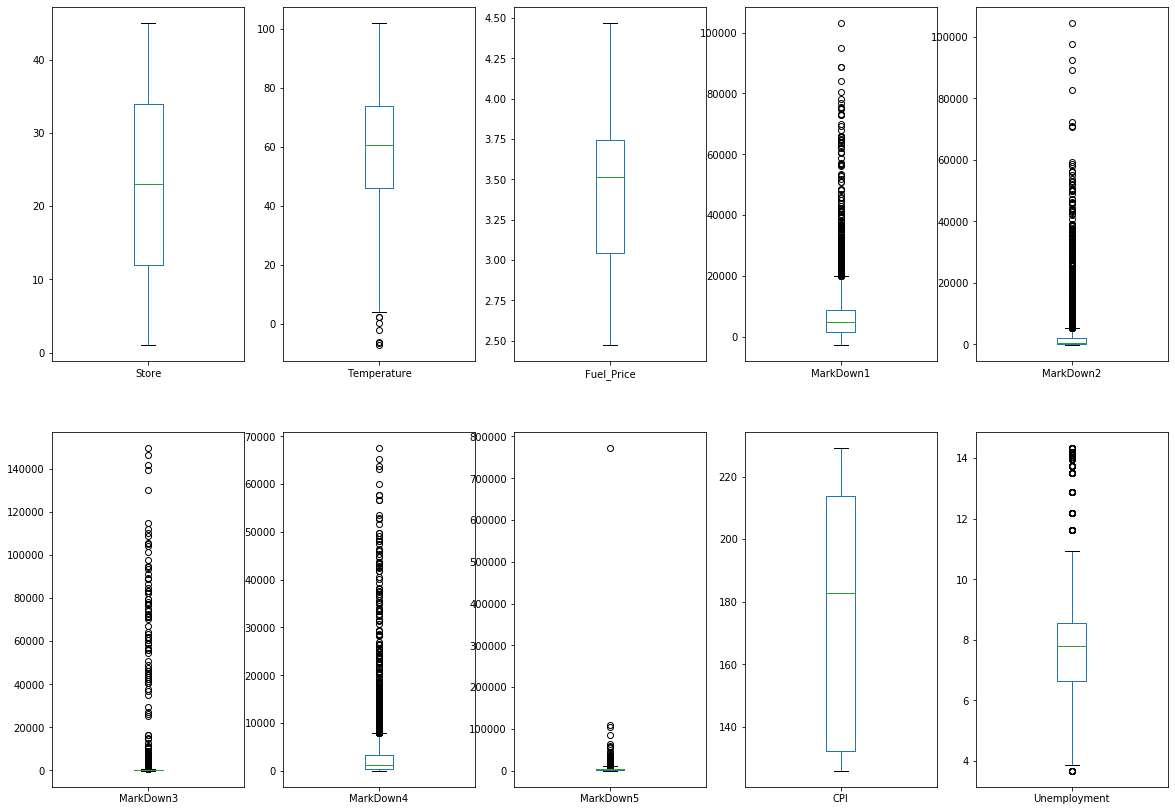

In [15]:
features.plot(kind='box', subplots=True, layout=(4,5), figsize=(20,30))

In [16]:
features.loc[features['MarkDown5'] == features['MarkDown5'].max()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
5059,28,2012-11-16,49.39,3.834,10431.55,184.51,42.72,1422.57,771448.1,131.3258,10.199,False


In [17]:
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [20]:
df.loc[df['Store']==1].loc[df['Dept']==1]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
73,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
145,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
218,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
290,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9883,1,1,2012-09-28,18947.81,False,76.08,3.666,3666.27,7.64,1.65,1417.96,4744.28,222.981658,6.908,A,151315
9956,1,1,2012-05-10,21904.47,False,68.55,3.617,8077.89,NaN,18.22,3617.43,3626.14,223.181477,6.573,A,151315
10028,1,1,2012-12-10,22764.01,False,62.99,3.601,2086.18,NaN,8.11,602.36,5926.45,223.381296,6.573,A,151315
10101,1,1,2012-10-19,24185.27,False,67.97,3.594,950.33,NaN,4.93,80.25,2312.85,223.425723,6.573,A,151315
